# Interpreting Heart Disease Predictions with LIME and SVM

#### Trustworthy AI Examples Series

This notebook demonstrates how black‐box models can hide critical misclassification drivers in clinical diagnoses. Using the Heart Disease dataset, this example scenario simulates a diagnostic pipeline that predicts coronary artery disease based on vital signs and lab results. Model interpretability is then performed, targeting local decision boundaries by applying case-specific explanation techniques, ultimately auditing misclassified cases to improve diagnostic confidence.

Many healthcare providers rely on complex classifiers (e.g., SVMs with RBF kernels) to flag at-risk patients, but when a healthy patient is falsely cleared, it can have life-threatening consequences. LIME offers a way to inspect why individual predictions went wrong, surfacing the top contributing features for false negatives or positives.

Through this scenario, readers will:

1. **Grasp the clinical implications**: why failing to explain misclassifications in heart‐disease screening undermines patient safety.
2. **Build end-to-end interpretable pipelines**: from preprocessing vital sign measurements to training an SVM to generating LIME explanations.
3. **Audit edge-case decisions**: use LIME visualizations to pinpoint which features drove each misclassified prediction.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

## Imports & Utilities

This notebook will use functions from the `preprocessing.py` file located in the `utils` folder. It is recommended to review the file to gain an understanding of the functions being used before continuing. Click [here](../../python/utils/preprocessing.py) to see the file.

### LIME

**LIME (Local Interpretable Model-agnostic Explanations)** is a technique for explaining individual predictions of any black-box classifier. It works by approximating the model locally with an interpretable surrogate model. It is used here for:

- `LimeTabularExplainer`: fit a local surrogate model around a specific prediction.
- `explain_instance`: generate a local explanation for a single prediction.
- `as_pyplot_figure`: visualize the top contributing features for that prediction.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import lime
import lime.lime_tabular

import python.utils.preprocessing as pp  

## Data Preparation

In order to train a model on the Heart Disease dataset, raw data must be converted into a clean, numeric, and standardized format. After loading the dataset from the CSV file, the first step is to handle any missing values to ensure consistency and avoid errors during model training.

In this case, missing values are imputed using the median of each column, which is a robust strategy that avoids data loss while mitigating the influence of outliers.

To prepare the dataset for modeling, first transform categorical variables using one-hot encoding, excluding the target to preserve its interpretability. Next, apply standardization to the numerical features to ensure they are on a comparable scale, which is crucial for many machine learning algorithms.

The `split_data` splits the data for model training and evaluation.

In [8]:
file_path = PROJECT_ROOT / 'data/heart_disease.csv'
df = pp.load_data(file_path)
df = pp.handle_missing_values(df, strategy='median')

target_col = 'target'

df_enc = pp.encode_categorical_data(df, method='onehot', exclude_cols=[target_col])
df_scaled = pp.scale_features(df_enc, method='standardize', exclude_cols=[target_col])

X_train, X_test, y_train, y_test = pp.split_data(df_scaled, target_col=target_col, test_size=0.2)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_test.shape[1] if X_train.shape[1] == X_test.shape[1] else -1}")

Training set size: 243 samples
Test set size: 61 samples
Number of features: 28


## SVM Model

### Model Training


The model used in this scenario is a **Support Vector Machine (SVM)** with an **RBF kernel**, wrapped in a pipeline with `StandardScaler` to ensure all features are on the same scale. SVMs are powerful classifiers that work well in high-dimensional spaces and are commonly used in clinical risk prediction due to their ability to model complex, non-linear decision boundaries.

In [9]:
model = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True, random_state=42))
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True, random_state=42))])

### Model Evaluation

After training, the model is evaluated on the test set using two key metrics:

- Accuracy (85.2%): — the proportion of correct predictions.
- ROC AUC (0.929): — the model’s ability to distinguish between patients with and without heart disease.

These results indicate that the SVM performs well, especially in terms of AUC, which is critical in medical diagnostics where false negatives can have serious consequences. However, high performance alone is not enough on its own. Understanding why the model makes certain predictions is essential for clinical trust and accountability.

In [5]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {auc:.3f}")

Accuracy: 0.852
ROC AUC: 0.929


## LIME Explainability

To understand why the model made a specific prediction (especially when it was incorrect) we apply LIME to a misclassified test case. This helps us audit the model’s decision boundary and identify which features contributed most to the error. The code below selects a single misclassified test case and applies LIME to generate a local explanation. The `LimeTabularExplainer` is initialized with the training data and feature names, and `explain_instance` is used to generate an explanation for the selected sample.

The resulting visualization shows the top 10 features that contributed to the model’s prediction for this specific case. Each bar represents a feature, with green bars indicating features that pushed the prediction toward the positive class (heart disease), and red bars indicating features that pushed it toward the negative class (no disease).

c:\Users\capett\sas-trustworthy-ai-examples\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


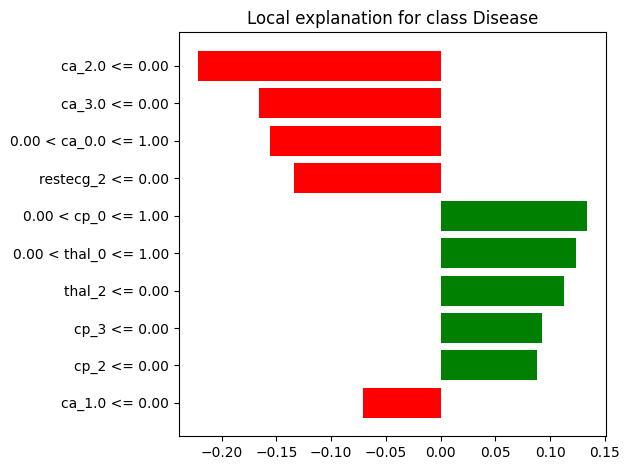

In [18]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=['No Disease', 'Disease'],
    mode='classification'
)


misclassified_idx = np.where(y_pred != y_test)[0][0]
sample = X_test.iloc[misclassified_idx].values

exp = explainer.explain_instance(
    data_row=sample,
    predict_fn=model.predict_proba,
    num_features=10
)

fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

## Takeaways

The LIME explanation reveals that features such as `cp_0`, `thal_0`, and `cp_3` contributed positively to the prediction of heart disease, while features like `ca_2.0`, `ca_3.0`, and `restecg_2` contributed negatively. This contrast highlights how the model's decision boundary can be influenced by subtle feature interactions, especially in edge cases. By surfacing these local explanations, clinicians and model developers can better understand why a prediction was made, even when it was incorrect. This supports more informed decision-making and helps identify patterns in misclassification.

## Conclusion

This scenario demonstrates how LIME can be used to audit individual predictions from a black-box model like an SVM. While the model achieved strong overall performance (Accuracy: 85.2%, ROC AUC: 0.929), local explanations are essential for identifying and understanding misclassifications—especially in high-stakes domains like healthcare.